In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import sys 
import utils
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---

# Hyperparameter

In [16]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 16
lr = 0.000001
opt = tf.keras.optimizers.Adam(lr)
ver = '02' #save version 
tfrecords_read_dir = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords/HGG/'

---

# Helper Functions

In [3]:
def dicesq(y_true, y_pred):
    '''
    Modified dice coefficient as refer to: https://arxiv.org/abs/1606.04797
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    :return: Modified dice coefficient
    '''
    nmr = 2*tf.reduce_sum(y_true*y_pred)
    dnmr = tf.reduce_sum(y_true**2) + tf.reduce_sum(y_pred**2) + tf.keras.backend.epsilon()
    return (nmr / dnmr)

def dicesq_loss(y_true, y_pred):
    '''
    Modified dice coefficient loss
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    '''
    return 1- dicesq(y_true, y_pred)

def dice_coef(y_true, y_pred):
    '''
    Dice coefficient for tensorflow
    '''
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + tf.keras.backend.epsilon()) / \
(tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + tf.keras.backend.epsilon())

def dice_coe(target, output, axis=(1, 2, 3), smooth=1e-5):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity
    of two batch of data, usually be used for binary image segmentation
    i.e. labels are binary. The coefficient between 0 to 1, 1 means totally match.

    Parameters
    -----------
    output : Tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    target : Tensor
        The target distribution, format the same with `output`.
    loss_type : str
        ``jaccard`` or ``sorensen``, default is ``jaccard``.
    axis : tuple of int
        All dimensions are reduced, default ``[1,2,3]``.
    smooth : float
        This small value will be added to the numerator and denominator.
            - If both output and target are empty, it makes sure dice is 1.
            - If either output or target are empty (all pixels are background), dice = ```smooth/(small_value + smooth)``, then if smooth is very small, dice close to 0 (even the image values lower than the threshold), so in this case, higher smooth can have a higher dice.

    Examples
    ---------
    >>> import tensorlayer as tl
    >>> outputs = tl.act.pixel_wise_softmax(outputs)
    >>> dice_loss = 1 - tl.cost.dice_coe(outputs, y_)

    References
    -----------
    - `Wiki-Dice <https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient>`__
    https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/cost.html
    """
    inse = tf.reduce_sum(output * target, axis=axis)
    l = tf.reduce_sum(output * output, axis=axis)
    r = tf.reduce_sum(target * target, axis=axis)
    dice = (2. * inse + smooth) / (l + r + smooth)
    dice = tf.reduce_mean(dice)
    return dice

def dice_coef_loss(y_true, y_pred):
    '''
    Dice coefficient loss for IOU
    '''
    return 1-dice_coe(y_true, y_pred)

def plot_comparison(input_img, caption, n_row=1, n_col=2, figsize=(10, 10), cmap = 'gray'):
    '''
    Plot comparison of multiple image but only in column wise!
    :param input_img: Input image list
    :param caption: Input caption list
    :param IMG_SIZE: Image size
    :param n_row: Number of row is 1 by DEFAULT
    :param n_col: Number of columns
    :param figsize: Figure size during plotting
    :return: Plot of (n_row, n_col)
    '''
    print()
    assert len(caption) == len(input_img), "Caption length and input image length does not match"
    assert len(input_img) == n_col, "Error of input images or number of columns!"

    fig, axes = plt.subplots(n_row, n_col, figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.7)

    for i in range(n_col):
        axes[i].imshow(np.squeeze(input_img[i]), cmap= cmap)
        axes[i].set_xlabel(caption[i])
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    plt.tight_layout()
    plt.show()

----

# Model

In [4]:
# from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
# from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
# from coord_conv import CoordConv

# def conv_block(x_in, filters, batch_norm = False, kernel_size=(3,3)):
#     x = Conv2D(filters, kernel_size, padding='same')(x_in)
#     if batch_norm==True:
#         x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Conv2D(filters, kernel_size, padding='same')(x)
#     if batch_norm==True:
#         x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     return x

# def coordconv_block(x_in, x_dim, y_dim, filters, batch_norm = False, kernel_size=(3,3), with_r = False):
#     x = Conv2D(filters, kernel_size, padding='same')(x_in)
#     if batch_norm==True:
#         x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = CoordConv(x_dim, y_dim, with_r, filters, kernel_size, padding='same')(x)
#     if batch_norm==True:
#         x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     return x

# def conv_2d(x_in, filters, batch_norm = False, kernel_size=(3,3),acti ='relu'):
#     x = Conv2D(filters, kernel_size, padding='same')(x_in)
#     if batch_norm==True:
#         x=BatchNormalization()(x)
#     x= Activation(acti)(x)
#     return x
    
# def pool(x_in, pool_size=(2, 2), type='Max'):
#     if type=='Max':
#         p = MaxPooling2D(pool_size)(x_in)
#     return p

# def up(x_in, filters, merge, batch_norm = False, size=(2,2)):
#     u = UpSampling2D(size)(x_in)
#     conv = conv_2d(u, filters, batch_norm)
#     concat = tf.concat([merge, conv],axis=-1)
#     return concat
    
# def Unet_model(input_layer):
#     #downsampling
# #     conv1 = coordconv_block(input_layer, x_dim=240, y_dim=240, filters=64)
#     conv1 = conv_block(input_layer, filters=64)
#     pool1 = pool(conv1)
    
#     conv2 = conv_block(pool1, filters=128)
#     pool2 = pool(conv2)
    
#     conv3 = conv_block(pool2, filters=256)
#     pool3 = pool(conv3)
    
#     conv4 = conv_block(pool3, filters=512)
#     pool4 = pool(conv4)
    
#     conv5 = conv_block(pool4, filters=1024)
    
#     #upsampling
#     up1 = up(conv5,filters=512, merge=conv4)
# #     conv6 = coordconv_block(up1, x_dim=30, y_dim=30, filters=512)
#     conv6 = conv_block(up1, filters=512)
    
#     up2 = up(conv6, filters=256, merge=conv3)
#     conv7 = conv_block(up2, filters=256)
    
#     up3 = up(conv7, filters=128, merge=conv2)
#     conv8 = conv_block(up3, filters=128)
    
#     up4 = up(conv8, filters=64, merge=conv1)
#     conv9 = conv_block(up4, filters=64)
    
#     #on paper filters = 2
#     output_layer = Conv2D(4, (1,1), activation = 'softmax')(conv9)
    
#     return output_layer

In [5]:
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
# Build U-Net model
dropout=0.2
hn = 'he_normal'
def unet_model(inputs):
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv4)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(drop5))
    merge6 = tf.concat([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(conv6))
    merge7 = tf.concat([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(conv7))
    merge8 = tf.concat([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(conv8))
    merge9 = tf.concat([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv9) 
    return conv10 

In [6]:
input_layer = Input(shape=(240,240,4))
Unet = Model(input_layer, unet_model(input_layer))

In [7]:
#to do..Sensitivity
xent = tf.keras.losses.CategoricalCrossentropy()
@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = Unet(image)
        loss = xent(label, model_output)
    gradients = tape.gradient(loss, Unet.trainable_variables)
    opt.apply_gradients(zip(gradients, Unet.trainable_variables))
    
    return model_output, loss, gradients

Epochs  1













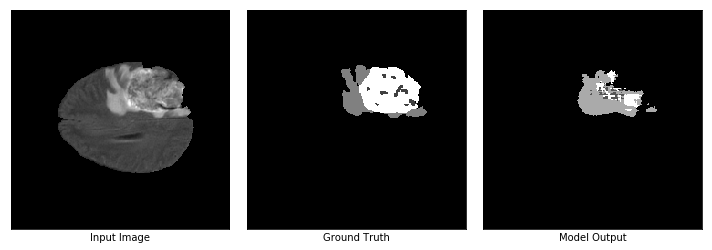

Steps: 2000, Loss:0.02513033151626587
Accurary: 0.9918403029441833
Gradient min:-0.0026048151776194572, max:0.0026034365873783827



Epochs  2













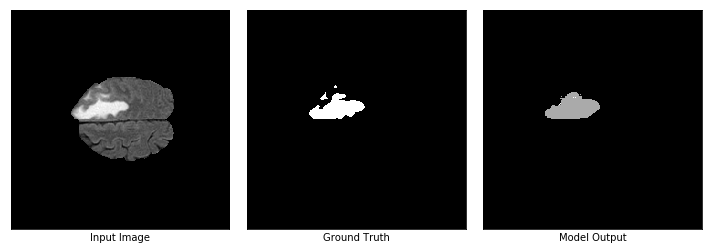

Steps: 2000, Loss:0.014522405341267586
Accurary: 0.993773877620697
Gradient min:-0.0020151955541223288, max:0.0010119025828316808



Epochs  3













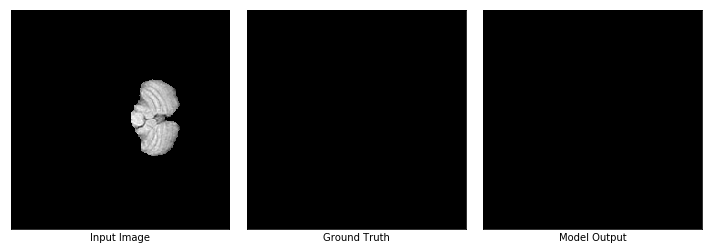

Steps: 2000, Loss:0.004590530879795551
Accurary: 0.9987131357192993
Gradient min:-0.006081227213144302, max:0.012442530132830143



Epochs  4













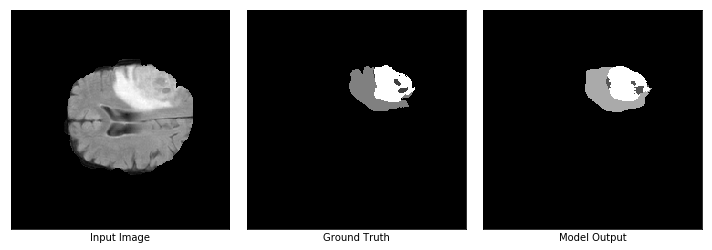

Steps: 2000, Loss:0.012650327757000923
Accurary: 0.992920994758606
Gradient min:-0.003603106364607811, max:0.008334225974977016



Epochs  5













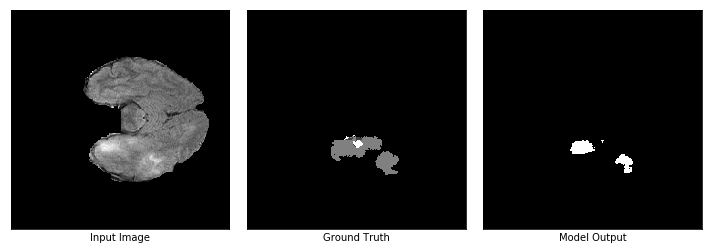

Steps: 2000, Loss:0.011380516923964024
Accurary: 0.9952072501182556
Gradient min:-0.005750474985688925, max:0.003810176160186529



Epochs  6













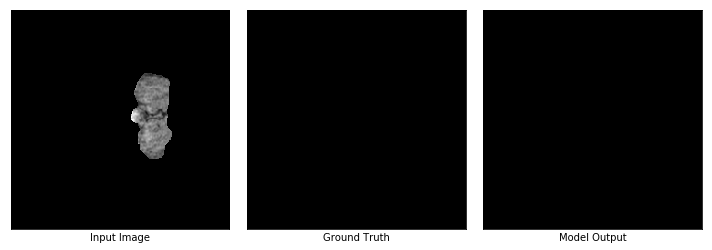

Steps: 2000, Loss:0.004321335349231958
Accurary: 0.9984961152076721
Gradient min:-0.0017281733453273773, max:0.0025369178038090467



Epochs  7













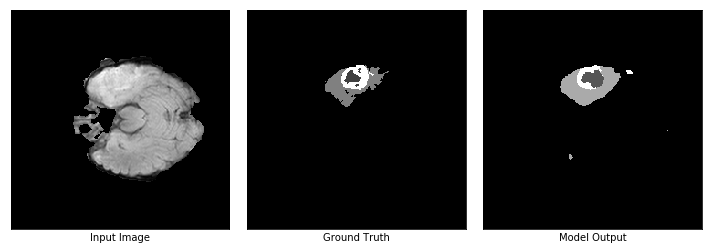

Steps: 2000, Loss:0.013072281144559383
Accurary: 0.9932649731636047
Gradient min:-0.018258344382047653, max:0.03466976433992386



Epochs  8













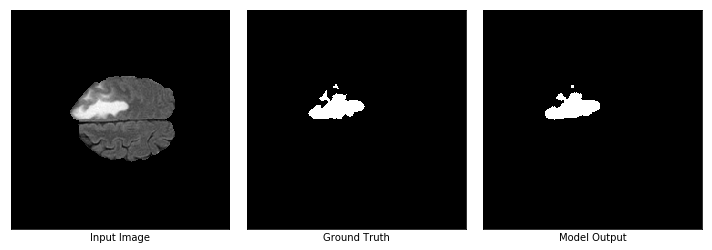

Steps: 2000, Loss:0.004921249113976955
Accurary: 0.9970876574516296
Gradient min:-0.0022894961293786764, max:0.003972009755671024



Epochs  9













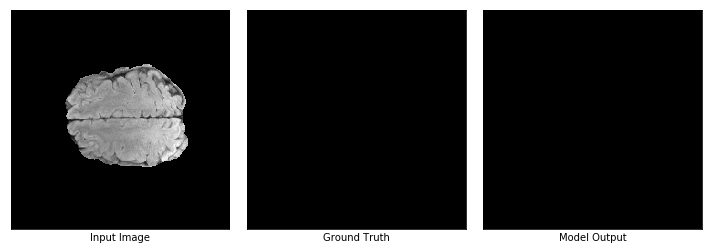

Steps: 2000, Loss:0.008100183680653572
Accurary: 0.9961925148963928
Gradient min:-0.0042318799532949924, max:0.006468393839895725



Epochs 10













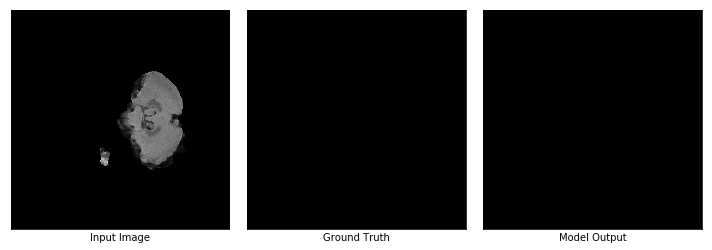

Steps: 2000, Loss:0.008261092938482761
Accurary: 0.99344402551651
Gradient min:-0.003089179750531912, max:0.004810794722288847



Epochs 11













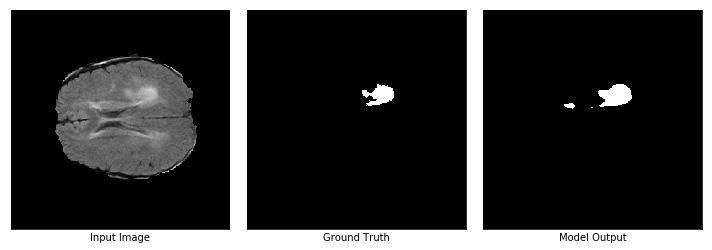

Steps: 2000, Loss:0.010453510098159313
Accurary: 0.9936979413032532
Gradient min:-0.002427602419629693, max:0.003075625281780958



Epochs 12













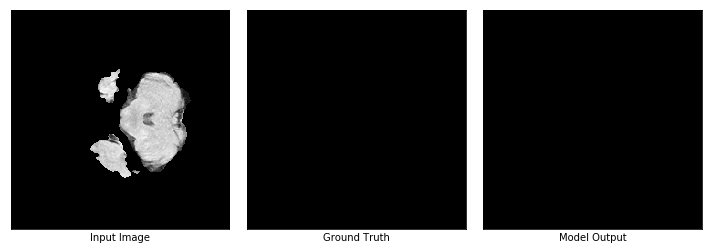

Steps: 2000, Loss:0.009474952705204487
Accurary: 0.9910764098167419
Gradient min:-0.003833754686638713, max:0.0034936449956148863



Epochs 13













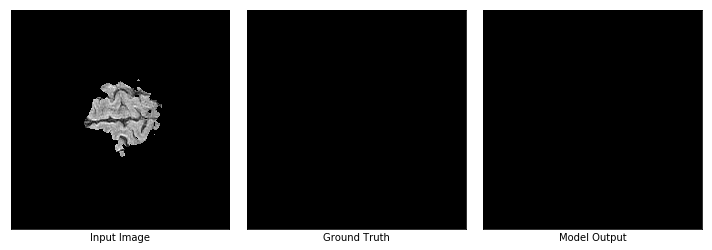

Steps: 2000, Loss:0.00988788902759552
Accurary: 0.9916514754295349
Gradient min:-0.0020621600560843945, max:0.002897064434364438



Epochs 14













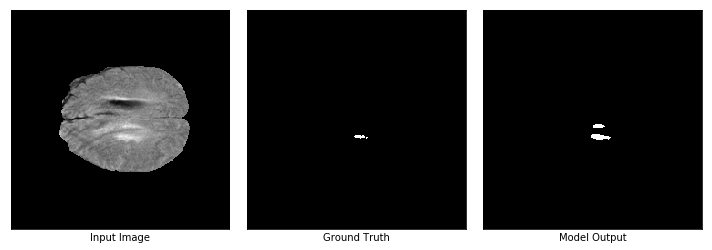

Steps: 2000, Loss:0.005958299618214369
Accurary: 0.9962608218193054
Gradient min:-0.00271010072901845, max:0.0019792194943875074



Epochs 15













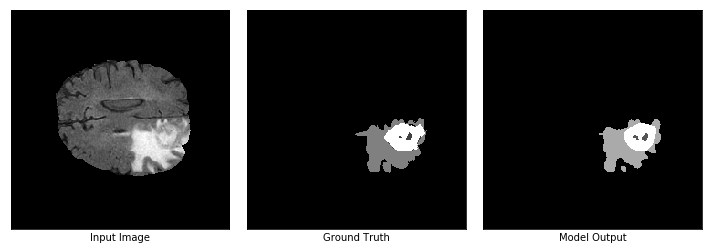

Steps: 2000, Loss:0.005886284168809652
Accurary: 0.996372640132904
Gradient min:-0.001696812454611063, max:0.001572038629092276



Epochs 16













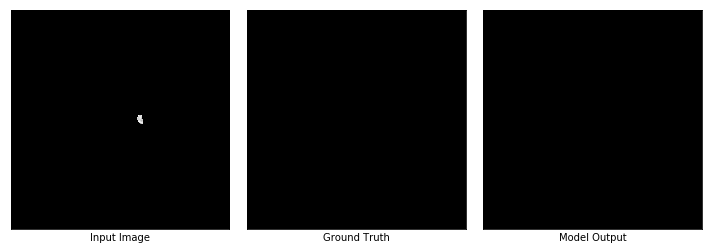

Steps: 2000, Loss:0.009210614487528801
Accurary: 0.9938856363296509
Gradient min:-0.0037843212485313416, max:0.005880685523152351



Epochs 17













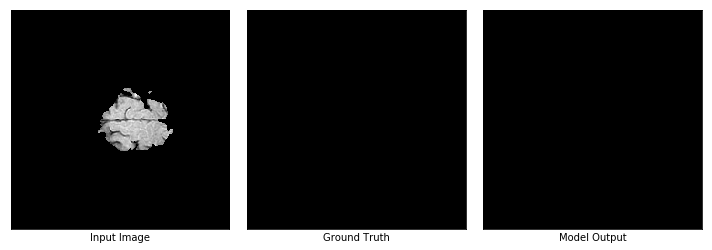

Steps: 2000, Loss:0.004586047492921352
Accurary: 0.9974815249443054
Gradient min:-0.0014455555938184261, max:0.0010753364767879248



Epochs 18













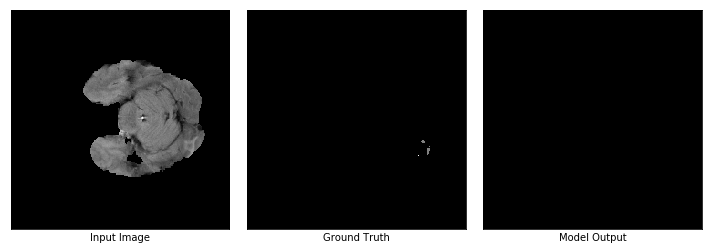

Steps: 2000, Loss:0.0041811419650912285
Accurary: 0.9970540404319763
Gradient min:-0.0005285341758280993, max:0.0005727476673200727



Epochs 19













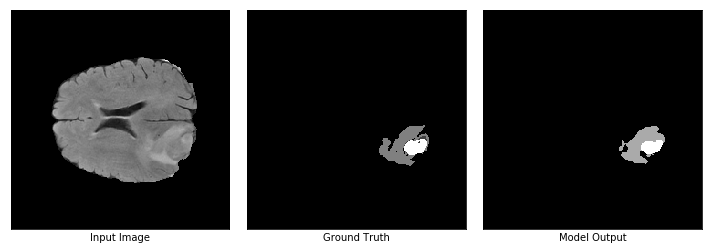

Steps: 2000, Loss:0.010291044600307941
Accurary: 0.9945681691169739
Gradient min:-0.0062057035975158215, max:0.0059231240302324295



Epochs 20













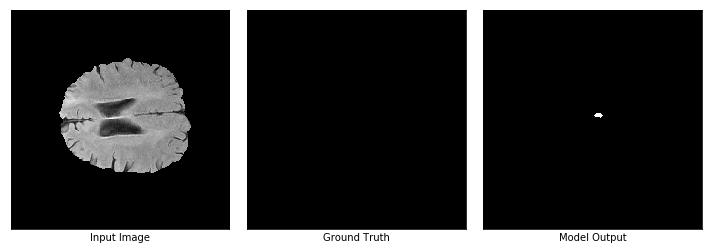

Steps: 2000, Loss:0.004048604052513838
Accurary: 0.9969140887260437
Gradient min:-0.0013011334231123328, max:0.0015718835638836026



Epochs 21













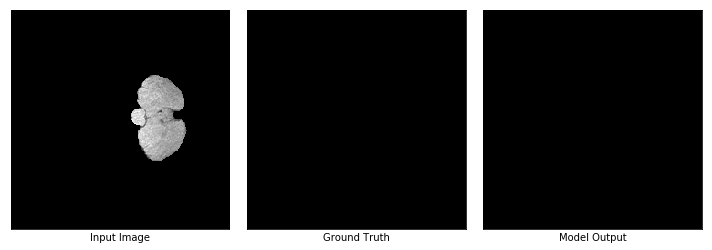

Steps: 2000, Loss:0.005515909753739834
Accurary: 0.9959146976470947
Gradient min:-0.0014949452597647905, max:0.0024420057889074087



Epochs 22













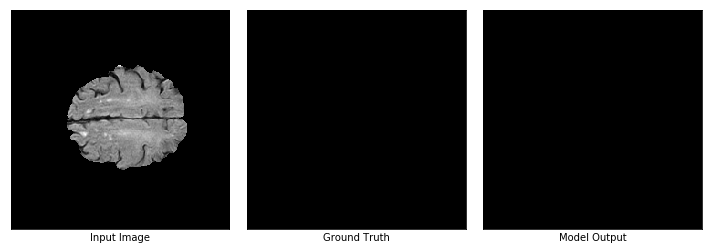

Steps: 2000, Loss:0.005498659331351519
Accurary: 0.9954937100410461
Gradient min:-0.0024365433491766453, max:0.0023162553552538157



Epochs 23













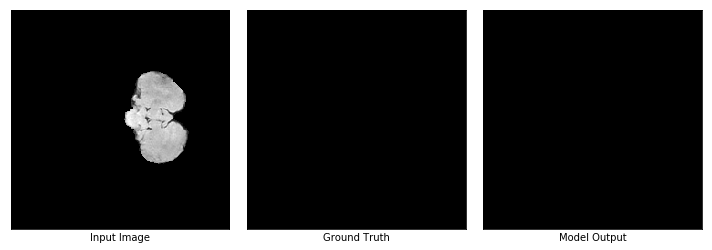

Steps: 2000, Loss:0.0028643226251006126
Accurary: 0.9968836903572083
Gradient min:-0.0008233787375502288, max:0.0007822090410627425



Epochs 24













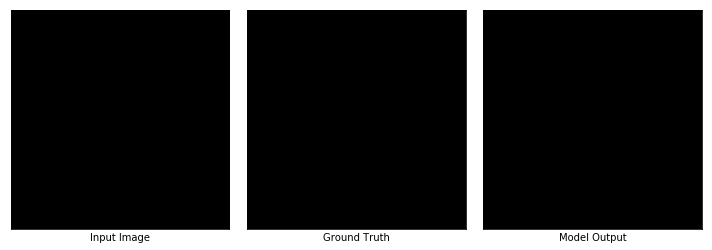

Steps: 2000, Loss:0.004661147948354483
Accurary: 0.9964930415153503
Gradient min:-0.0009965136414393783, max:0.0006750122411176562



Epochs 25













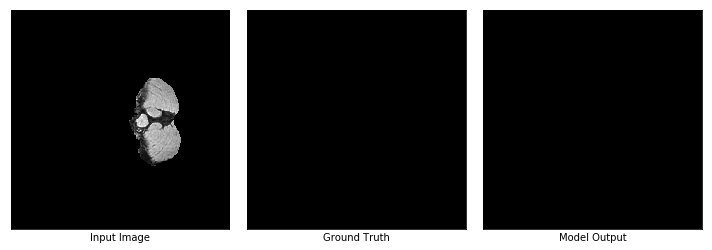

Steps: 2000, Loss:0.0074685621075332165
Accurary: 0.9954069256782532
Gradient min:-0.006530899088829756, max:0.010490783490240574



Epochs 26













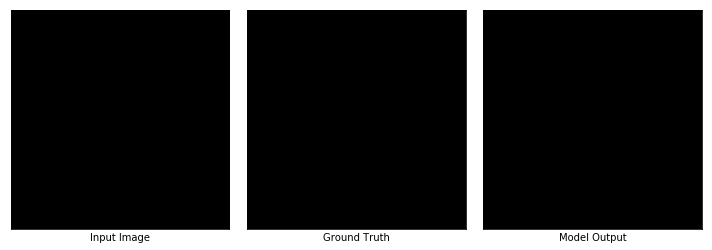

Steps: 2000, Loss:0.00732756732031703
Accurary: 0.9913411736488342
Gradient min:-0.002187516540288925, max:0.0019182340474799275



Epochs 27













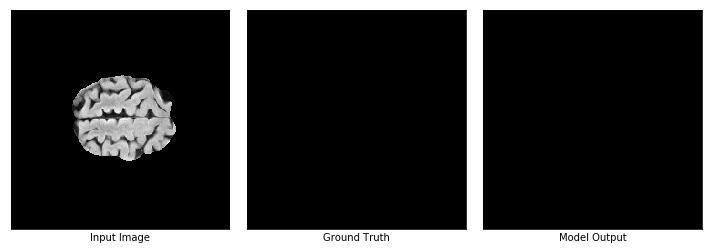

Steps: 2000, Loss:0.006918842438608408
Accurary: 0.9941959381103516
Gradient min:-0.005195920821279287, max:0.0038509739097207785



Epochs 28













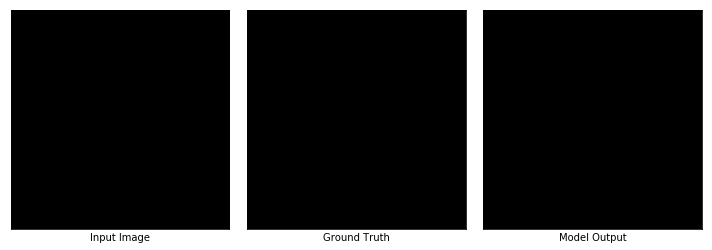

Steps: 2000, Loss:0.0013039592886343598
Accurary: 0.999524712562561
Gradient min:-0.0019944694358855486, max:0.001491439645178616



Epochs 29













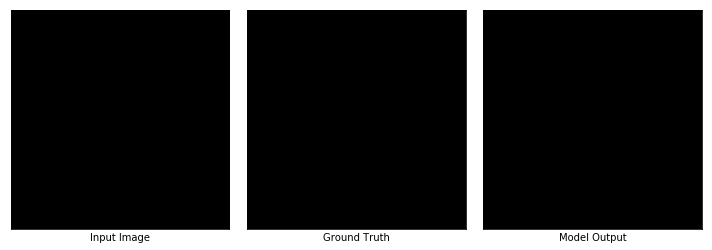

Steps: 2000, Loss:0.005356102716177702
Accurary: 0.9959136247634888
Gradient min:-0.002820140914991498, max:0.0039392393082380295



Epochs 30













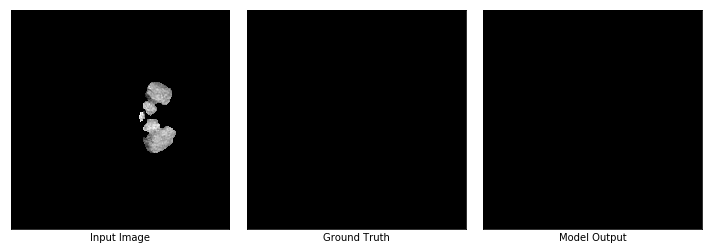

Steps: 2000, Loss:0.003448768286034465
Accurary: 0.9963834881782532
Gradient min:-0.0005421267705969512, max:0.0005814051837660372





In [8]:
epochs = 1
max_epochs = 30
predicted_img = []
groundtruth_img = []
loss_list = []
dice_list = []
acc_list = []
while epochs <= max_epochs:
    print("Epochs {:2d}".format(epochs))
    print()
    steps = 1
    for tf_re in sorted(os.listdir(tfrecords_read_dir)):
#         print(tf_re)
        print()
        tf_dir = os.path.join(tfrecords_read_dir+tf_re)
        dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        acc_inner = []
        for imgs in dataset:
            image = imgs[:,:,:,:4]
            #unprocessed label for plotting 
            label = imgs[:,:,:,-1]
            label_plot = tf.cast(label,tf.int32)
            #for simplicity label 4 will be converted to 3 for sparse encoding
            label = tf.where(label==4,3,label)
            label = tf.keras.utils.to_categorical(label, num_classes=4)
            img_seg, loss, gradients = train_fn(image, label) #training function 
            img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) #map from sparse to label
            #accuracy of the output values for that batch
            acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label_plot), tf.float32))
#             dice_score = dice_coef(label, img_seg)
            acc_inner.append(acc)
#             dice_list.append(dice_score) #append dice score for every every images
            
            #output
            if steps%2000==0:
                input_img = [image[0,:,:,0], label_plot[0], img_seg[0]]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3)
                
                predicted_img.append(img_seg[0])
                groundtruth_img.append(label_plot[0])
                loss_list.append(loss)
#                 dice_coe = dice_coef(label[0], img_seg[0])
#                 print("Steps: {}, Loss:{}, Dice Score:{}".format(steps, loss, dice_coe))
                print("Steps: {}, Loss:{}".format(steps, loss))
                print("Accurary: {}".format(acc))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
        acc_list.append(np.mean(acc_inner))
#         print("Average Dice Coefficient: {}".format(np.mean(np.array(dice_list))))
    epochs+=1 

---

# Save Weights

In [17]:
Unet.save_weights('model_weights/Unet_{}.h5'.format(ver))

---

# Validation 

In [18]:
def val_fn(image, label):
    Unet.load_weights('model_weights/Unet_{}.h5'.format(ver))
    Unet.trainable = False
    model_output = Unet(image)
    loss = xent(label, model_output)
    return model_output, loss

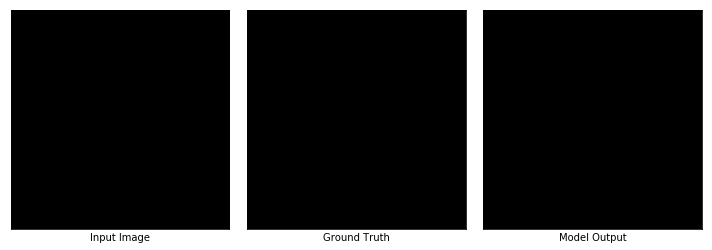

Steps: 100, Loss:0.01790126971900463
Accurary: 0.9942567348480225



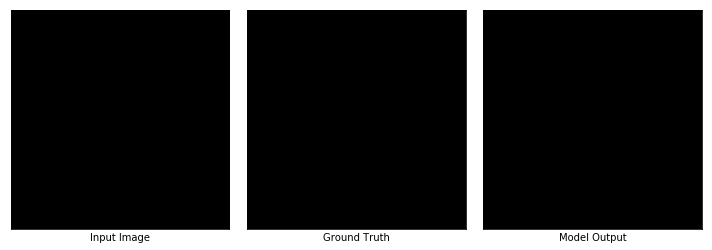

Steps: 200, Loss:0.021420493721961975
Accurary: 0.9946538805961609



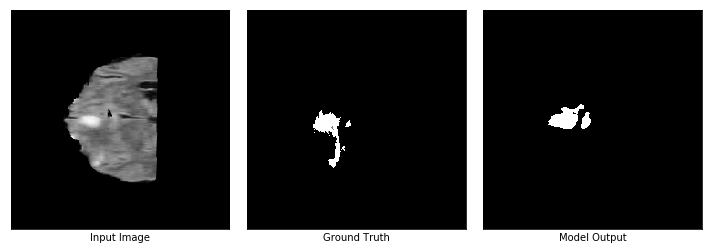

Steps: 300, Loss:0.04762888699769974
Accurary: 0.9919813275337219



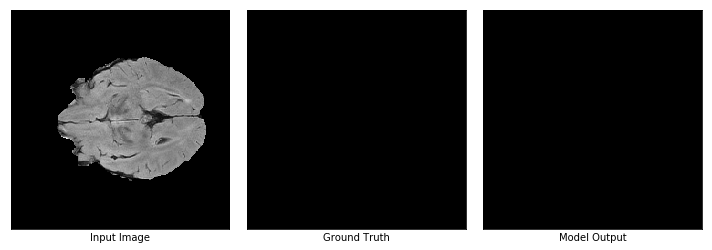

Steps: 400, Loss:0.09886611253023148
Accurary: 0.984669029712677



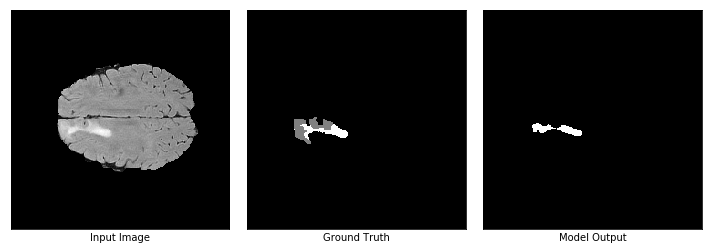

Steps: 500, Loss:0.04205150157213211
Accurary: 0.9933409094810486



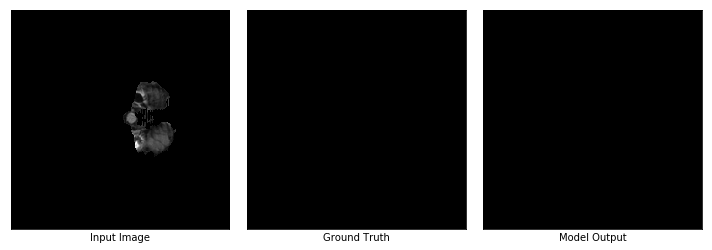

Steps: 600, Loss:0.07466501742601395
Accurary: 0.9904329180717468



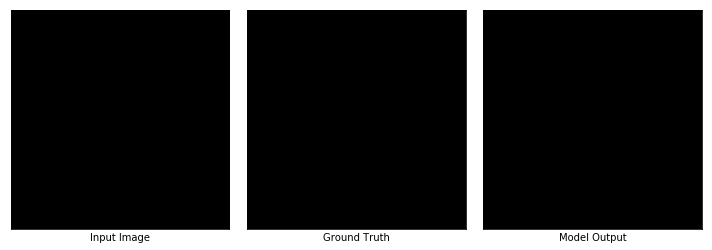

Steps: 700, Loss:0.041808780282735825
Accurary: 0.9932801723480225


In [19]:
tfrecords_val = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords/LGG/'

steps = 1
for tf_re in sorted(os.listdir(tfrecords_val)):
    tf_dir = os.path.join(tfrecords_val+tf_re)
    dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
    for imgs in dataset:
        image = imgs[:,:,:,:4]
        #unprocessed label for plotting 
        label = imgs[:,:,:,-1]
        label_plot = tf.cast(label,tf.int32)
        #for simplicity label 4 will be converted to 3 for sparse encoding
        label = tf.where(label==4,3,label)
        label = tf.keras.utils.to_categorical(label, num_classes=4)
        img_seg, loss = val_fn(image, label) #training function 
        img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) #map from sparse to label
        #accuracy of the output values for that batch
        acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label_plot), tf.float32))
        acc_inner.append(acc)
        #output
        if steps%100==0:
            input_img = [image[0,:,:,0], label_plot[0], img_seg[0]]
            caption = ['Input Image', 'Ground Truth', 'Model Output']
            plot_comparison(input_img, caption, n_col = 3)
            print("Steps: {}, Loss:{}".format(steps, loss))
            print("Accurary: {}".format(acc))
        steps+=1

---

# Model Summary

In [9]:
# Unet.summary()